# Graph Auto-Encoder para detección de anomalías



### Introducción
Identificar comportamientos anómalos entre distribuidores de componentes electrónicos es fundamental para asegurar la calidad de los datos, la coherencia en precios y la confiabilidad de la cadena de suministro. Este notebook propone un enfoque híbrido y no supervisado para la detección de anomalías, combinando autoencoders de grafos (GAE) con métodos clásicos basados en atributos tabulares. Se construye un grafo donde los nodos representan distribuidores y las conexiones reflejan similitud en características como niveles de stock, puntos de precio y mínimos de compra (MOQ). Se entrenan modelos de GAE para detectar anomalías mediante el error de reconstrucción, los cuales se comparan con modelos Isolation Forest aplicados tanto a los atributos originales (IF(x)) como a los embeddings latentes (IF(z)). Los resultados muestran que sólo 8 de 22 anomalías se superponen entre métodos, lo que resalta su complementariedad

### Datos

Octopart es una base de datos que incluye información sobre fabricantes, distribuidores, precios, niveles de stock, tiempo de entrega y otras características relacionadas con componentes electrónicos. 

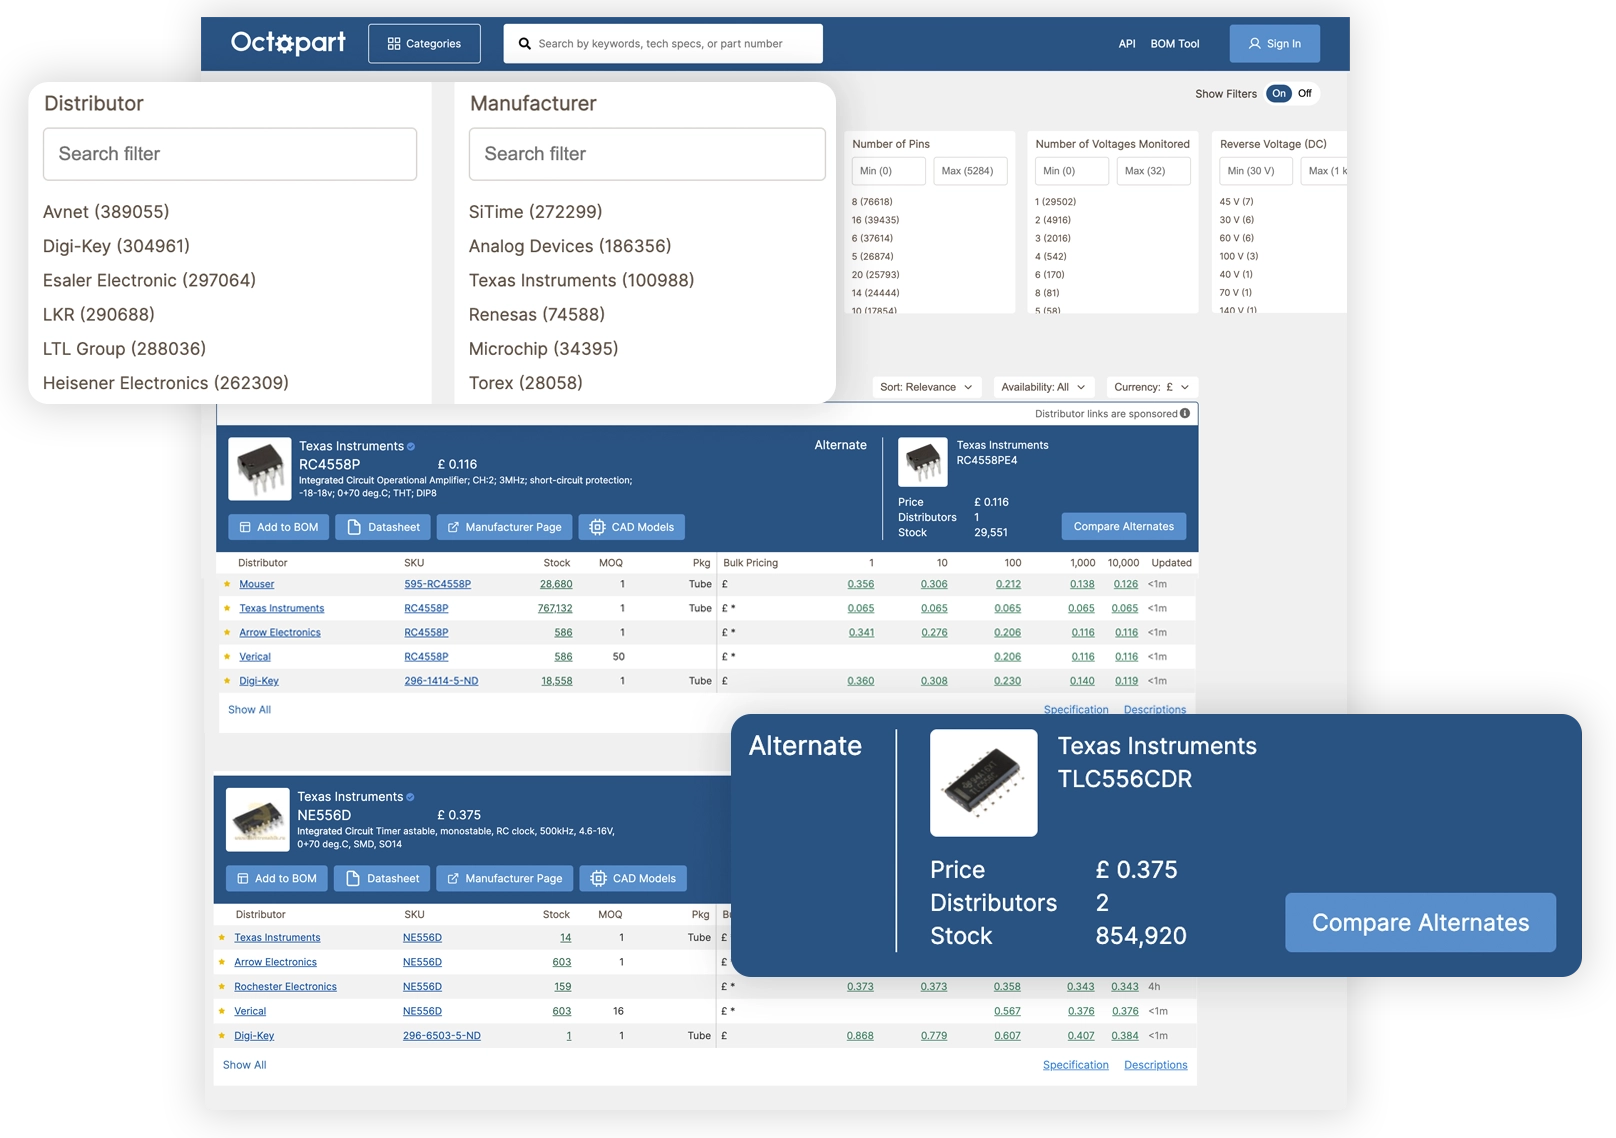

La información es utilizada por varias empresas que compran componentes electronicos, por lo que al tomar la mejor decisión de que distribuidor elegir para comprar la parte electronica se debe considerar varios aspectos - precio, stock, MOQ, etc., pero también si este distribuidor puede considerar como anamolo o no. 

Una anomalia potencial puede suceder cuando un distribuidor maneja precios fuera de rango en comparación con otros distribuidores, para detecer este detalle es necesario realizar algunos analisis de detección de anomalias. 

Esta información puede ser modelada naturalmente como un grafo, donde los nodos y bordes representan relaciones complejas.



### Arquitectura general

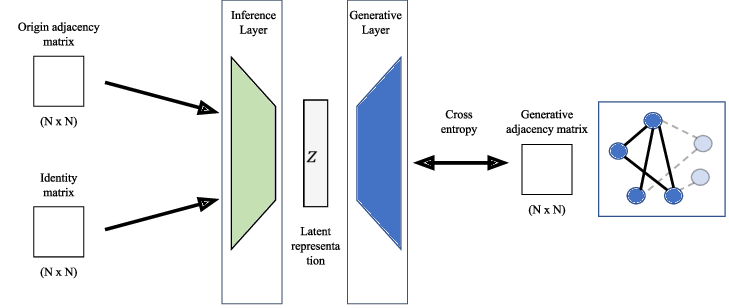

### Paqueterias

In [ ]:
%pip install tabulate
%pip install umap-learn
%pip install matplotlib-venn

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv,GAE
from sklearn.metrics.pairwise import euclidean_distances
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from scipy.stats import skew, kurtosis
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Datos

In [2]:
df = pd.read_csv(r"C:\Users\SESA626862\OneDrive - Schneider Electric\Codes\WebScrapping\MPN_OCTOPART_BATCH\octopart_output.csv" ,encoding='latin',on_bad_lines = "skip")
df = df[df['companyName'] != 'companyName']
### rellenando mpn's
df['mpn'] = df['mpn'].fillna(method='ffill')

C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\505414385.py:1: DtypeWarning: Columns (0,6,14,15,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\SESA626862\OneDrive - Schneider Electric\Codes\WebScrapping\MPN_OCTOPART_BATCH\octopart_output.csv" ,encoding='latin',on_bad_lines = "skip")
C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\505414385.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['mpn'] = df['mpn'].fillna(method='ffill')


In [3]:
## Cuantos distribuidores distintos tenemos
len(df['companyName'].unique())
## Cuantos manufacturer part number tenemos
len(df['mpn'].unique(
))

199

# 2. Preprocesamiento de datos

In [5]:
df['Distributor + Country'] =  df['companyName'] + "_" + df['country'] ## Se realiza un concatenado entre los distribuidores y donde residen

In [110]:
df_ = df[['mpn','country','companyName','Distributor + Country','Authorized Distributor','inventoryLevel','moq','1', '10', '25', '50', '100',
       '250', '500', '1000', '2500', '5000', '10000', '25000', '50000']] ## Solo se elijen las variables con las que se va a modelar

## Se rellenan los datos vacíos con el método ffill para algunas columnas especificas 
df_['Distributor + Country'] = df_['Distributor + Country'].fillna(method='ffill')
df_['Authorized Distributor'] = df_['Authorized Distributor'].fillna(method='ffill')
df_['Authorized Distributor'] = df_['Authorized Distributor'].astype(str).str.strip().str.lower().map({'true': 1, 'false': 0})

## Se eliminan las filas que no tienen información en las siguientes columnas
df_clean = df_.dropna(subset=['companyName','inventoryLevel','Authorized Distributor','1', '10', '25', '50', '100',
       '250', '500', '1000', '2500', '5000', '10000', '25000', '50000'])

df_ok = df_clean[['Distributor + Country','mpn','moq','inventoryLevel','1', '10', '25', '50', '100',
       '250', '500', '1000', '2500', '5000', '10000', '25000', '50000']]

df_ok['inventoryLevel'] = pd.to_numeric(df_ok['inventoryLevel'],errors='coerce')

df_ok['inventoryLevel'] = df_ok['inventoryLevel'].apply(lambda x: max(x,0)) 

df_ok['moq'] = df_clean['moq'].fillna(1)
df_ok['moq'] = pd.to_numeric(df_ok['moq'],errors='coerce')

In [13]:
df_ok

,Distributor + Country,mpn,moq,inventoryLevel,1,10,25,50,100,250,500,1000,2500,5000,10000,25000,50000
0,DigiKey_US,FDS2582,1.0,5564.0,1.8100,1.8100,1.1540,1.1540,1.1540,0.77650,0.77650,0.61482,0.56281,0.56281,0.56281,0.56281,0.56281
3,Mouser_US,FDS2582,1.0,6627.0,1.7600,1.7600,1.1300,1.1300,1.1300,0.76300,0.76300,0.76300,0.57500,0.57500,0.57500,0.54700,0.54700
4,Newark_US,FDS2582,2500.0,0.0,0.6580,0.6580,0.6580,0.6580,0.6580,0.65800,0.65800,0.65800,0.65800,0.63200,0.57400,0.49800,0.48600
7,Onlinecomponents.com_US,FDS2582,2500.0,0.0,0.4904,0.4904,0.4904,0.4904,0.4904,0.49040,0.49040,0.49040,0.49040,0.49040,0.47220,0.45820,0.45820
8,Arrow Electronics_US,FDS2582,2500.0,0.0,0.4590,0.4590,0.4590,0.4590,0.4590,0.45900,0.45900,0.45900,0.45900,0.45900,0.45900,0.45900,0.45900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524252,"Fmall Co., Limited_HK",ADUM3210WARZ-RL7,1.0,19000.0,2.1251,2.1251,2.1251,2.1251,2.1251,1.98800,1.98800,1.98800,1.87370,1.87370,1.87370,1.71380,1.71380
1524253,Bettlink_HK,ADUM3210WARZ-RL7,1.0,11892.0,2.1252,2.1252,1.9320,1.9320,1.9320,1.77248,1.77248,1.64118,1.53381,1.53381,1.53381,1.53381,1.53381
1524254,SHENGYU ELECTRONICS_CN,ADUM3210WARZ-RL7,1.0,7448.0,5.6264,5.6264,5.5139,5.5139,5.5139,5.34510,5.34510,5.34510,5.17630,5.17630,5.17630,4.95120,4.95120
1524255,Chipsmall Limited_CN,ADUM3210WARZ-RL7,1.0,18.0,4.2420,4.2420,3.8178,3.8178,3.8178,2.43915,2.43915,2.33310,2.12100,2.12100,2.12100,2.12100,2.12100


# 3. Similaridad

### Estandarización de los datos

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define a function to apply log-scaling and then standardization within each group
def scale_mpn(group):
    # Extract the features to scale
    features = group[['moq', 'inventoryLevel', '1', '10', '25', '50', '100',
                      '250', '500', '1000', '2500', '5000', '10000', '25000', '50000']]
    
    #features = features.apply(pd.to_numeric,errors= 'coerce')
    # Apply log transformation to handle variability
    features = features.applymap(lambda x: x if x > 0 else 1e-10)
    log_features = np.log1p(features)
    
    # Initialize and apply the scaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(log_features)
    
    # Create a new DataFrame with the scaled features and original columns
    scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=group.index)
    
    # Add back the non-scaled columns
    scaled_df['Distributor + Country'] = group['Distributor + Country']
    scaled_df['mpn'] = group['mpn']
    
    return scaled_df

# Apply the scaling function to each MPN group and combine the results
standardized_data = df_ok.groupby('mpn', group_keys=False).apply(scale_mpn).reset_index(drop=True)

# Display the standardized data
print(standardized_data)


Para este caso, se ha de utilizar la distancia euclideana. Este es simple y conocida. Además que para nuestro caso, queremos observar si dos distribuidores tienen precios similares para múltiples cantidades. 

In [190]:
mpn_groups = standardized_data[['Distributor + Country','mpn','moq','inventoryLevel','1', '10', '25', '50', '100',
       '250', '500', '1000', '2500', '5000', '10000', '25000', '50000']].groupby('mpn')

similarity_dict = {}


for mpn, group in mpn_groups: 
    distributors = group['Distributor + Country'].values
    prices = group[['moq','inventoryLevel','1', '10', '25', '50', '100',
       '250', '500', '1000', '2500', '5000', '10000', '25000', '50000']].values
    
    ## calcular la matriz de correlación

    prices_ = group.set_index('Distributor + Country')[['moq','inventoryLevel','1', '10', '25', '50', '100',
       '250', '500', '1000', '2500', '5000', '10000', '25000', '50000']]
    
    #corr_matrix = prices_.T.corr(method='pearson')


    ## calcular la similaridad
    similarity_matrix = euclidean_distances(prices)

    for i, dist1 in enumerate(distributors):
        for j, dist2 in enumerate(distributors):

            if dist1 != dist2:
                similarity_dict[(dist1,dist2,mpn)] = similarity_matrix[i,j]
                #correlations_by_mpn[(dist1,dist2,mpn)] = corr_matrix.iloc[i,j]

similarity_df = pd.DataFrame(list(similarity_dict.items()), columns= ['Par','Similarity'])
#corr_df = pd.DataFrame(list(correlations_by_mpn.items()), columns= ['Par','Corr'])


KeyboardInterrupt: 

In [17]:
similarity_df

,Par,Similarity
0,"(DigiKey_US, Newark_US, #A915AY-100M=P3)",2.233425
1,"(DigiKey_US, TTI_US, #A915AY-100M=P3)",3.614856
2,"(DigiKey_US, element14 APAC_SG, #A915AY-100M=P3)",3.123441
3,"(DigiKey_US, Farnell_GB, #A915AY-100M=P3)",2.348436
4,"(DigiKey_US, One Stop Electro_US, #A915AY-100M...",6.369639
...,...,...
22178452,"(Schukat_DE, Arrow Electronics_US, ZY33)",5.258895
22178453,"(Schukat_DE, Master Electronics_US, ZY33)",3.336393
22178454,"(Schukat_DE, DigiKey_US, ZY33)",7.072408
22178455,"(Schukat_DE, Verical_US, ZY33)",2.559847


Dado que es una cercania entre pares, se han obtenido pares repetidos por lo que se hará un merge entre los pares (x1,y1) y (y2,x2) donde x2=x1 y y2=y1 y luego se obtendrá el avg de las sumas de los pares iguales 

In [18]:
overall_similarity = {}
tuple_count = {}

# Accumulate similarity and count the number of appearances of each tuple (dist1, dist2)
for (dist1, dist2, mpn), sim in similarity_dict.items():
    overall_similarity[(dist1, dist2)] = overall_similarity.get((dist1, dist2), 0) + sim
    tuple_count[(dist1, dist2)] = tuple_count.get((dist1, dist2), 0) + 1

# Convert to DataFrame
overall_similarity_df = pd.DataFrame(list(overall_similarity.items()), columns=['Par', 'Total_Similarity'])

# Calculate the average similarity based on the number of times each pair appears
overall_similarity_df['Avg_Similarity'] = overall_similarity_df['Par'].apply(
    lambda x: overall_similarity_df['Total_Similarity'][overall_similarity_df['Par'] == x].values[0] / tuple_count[x]
)

# View the result
overall_similarity_df



,Par,Total_Similarity,Avg_Similarity
0,"(DigiKey_US, Newark_US)",74603.590654,2.503308
1,"(DigiKey_US, TTI_US)",61984.072122,3.269375
2,"(DigiKey_US, element14 APAC_SG)",50830.604437,2.410633
3,"(DigiKey_US, Farnell_GB)",60856.695391,2.413224
4,"(DigiKey_US, One Stop Electro_US)",69467.792632,6.539376
...,...,...,...
18702,"(Rapid Electronics_GB, MRO Supply_US)",16.280145,4.070036
18703,"(Samtec_US, Aztech_IT)",11.083350,5.541675
18704,"(Aztech_IT, Samtec_US)",11.083350,5.541675
18705,"(Hyper Source Electronics_HK, Elcom Components...",1.801024,1.801024


In [19]:
# Sort the distributor pairs alphabetically within each row, ensuring consistency for duplicates
overall_similarity_df['Sorted_Par'] = overall_similarity_df['Par'].apply(lambda x: tuple(sorted(map(str, x))))

# Drop duplicate pairs based on the sorted pairs
similarity_df_unique = overall_similarity_df.drop_duplicates(subset='Sorted_Par').drop(columns='Sorted_Par')

print(similarity_df_unique)

                                                     Par  Total_Similarity  \
0                                (DigiKey_US, Newark_US)      74603.590654   
1                                   (DigiKey_US, TTI_US)      61984.072122   
2                        (DigiKey_US, element14 APAC_SG)      50830.604437   
3                               (DigiKey_US, Farnell_GB)      60856.695391   
4                      (DigiKey_US, One Stop Electro_US)      69467.792632   
...                                                  ...               ...   
18697                               (RFMW_US, Aztech_IT)          9.944544   
18698                        (RFMW_US, Semicontronic_US)          3.731034   
18701              (MRO Supply_US, Rapid Electronics_GB)         16.280145   
18703                             (Samtec_US, Aztech_IT)         11.083350   
18705  (Hyper Source Electronics_HK, Elcom Components...          1.801024   

       Avg_Similarity  
0            2.503308  
1            3.

### Umbral de cercanía (similaridad)

Se elije un threshold para solo quedarse con los distribuidores que están mas cercanos entre si

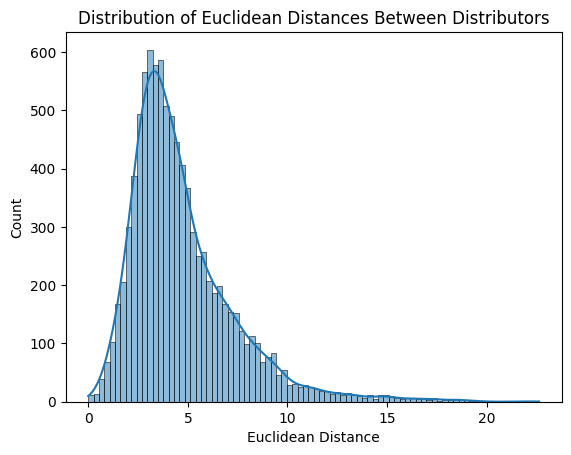

25th Percentile: 2.9581033395366605
50th Percentile (Median): 4.070636099885345
75th Percentile: 5.801390132644844
Mean Distance: 4.703797719024725
Standard Deviation: 2.6370806077175732


In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract distances from similarity_df
distances = similarity_df_unique['Avg_Similarity'].values

# Plot distribution
sns.histplot(distances, kde=True)
plt.xlabel("Euclidean Distance")
plt.title("Distribution of Euclidean Distances Between Distributors")
plt.show()

# Calculate percentiles
percentile_25 = np.percentile(distances, 25)
percentile_50 = np.percentile(distances, 50)
percentile_75 = np.percentile(distances, 75)
mean_distance = np.mean(distances)
std_dev_distance = np.std(distances)

print("25th Percentile:", percentile_25)
print("50th Percentile (Median):", percentile_50)
print("75th Percentile:", percentile_75)
print("Mean Distance:", mean_distance)
print("Standard Deviation:", std_dev_distance)

In [21]:
treshold_mean = mean_distance
treshold_25 = percentile_25
treshold_75 = percentile_75


edges= similarity_df_unique[similarity_df_unique['Avg_Similarity'] < treshold_mean]

In [22]:
edges

,Par,Total_Similarity,Avg_Similarity
0,"(DigiKey_US, Newark_US)",74603.590654,2.503308
1,"(DigiKey_US, TTI_US)",61984.072122,3.269375
2,"(DigiKey_US, element14 APAC_SG)",50830.604437,2.410633
3,"(DigiKey_US, Farnell_GB)",60856.695391,2.413224
5,"(DigiKey_US, Win Source_CN)",61725.095442,3.584292
...,...,...,...
18691,"(RFMW_US, Ampacity Systems_MY)",8.732720,4.366360
18694,"(Verical_US, RFMW_US)",3.675395,3.675395
18698,"(RFMW_US, Semicontronic_US)",3.731034,3.731034
18701,"(MRO Supply_US, Rapid Electronics_GB)",16.280145,4.070036


# 4. Matriz de caracteristicas y de conexión

"Final_2" se dejará con las valores absolutos (no estandarizados) para futuros análisis y "final" se estandarizará para utilizarlo como matriz de caracteristicas

Las caracteristicas (features) serán las siguientes - multi-statistic embeddings-:

Mean, Min, Max, Std, Skew (simetria) y kurtosis para los precios de 1 unidad, 1000 unidades y 5000 unidades, de manera similar para la variable de inventario (stock). 

Para Skew, nos ayudará a obtener la simetria de la distribución de los datos con respecto a su media. Un skew alto podría indicar que algunos distribuidores tienen MOQ o precios anormalmente altos, aunque la mayoria tenga valores normales
Para Kurtosis, nos ayuda a medir la concentración de los datos en el centro vs. en las colas. Un valor alto de kurtosis puede señalar que existen outliers fuertes, es decir, distribuidores muy distintos al resto en alguna caracteristica (feature) - como precios exagerados, MOQ extremos, etc.-

In [154]:
final_2 = df_ok.groupby(['Distributor + Country']).agg(
    Mean_MOQ1 = ('1','mean'),Max_MOQ1 = ('1','max'),Min_MOQ1 = ('1','min'),Std_MOQ1 = ('1','std'),sk_MOQ1 = ('1',skew),k_MOQ1 = ('1',kurtosis),
    Mean_MOQ1000 = ('1000','mean'),Max_MOQ1000 = ('1000','max'),Min_MOQ1000 = ('1000','min'),Std_MOQ1000 = ('1000','std'),sk_MOQ1000 = ('1000',skew),k_MOQ1000 = ('1000',kurtosis),
    Mean_MOQ5000 = ('5000','mean'),Max_MOQ5000 = ('5000','max'),Min_MOQ5000 = ('5000','min'),Std_MOQ5000 = ('5000','std'),sk_MOQ5000 = ('5000',skew),k_MOQ5000 = ('5000',kurtosis),
    Mean_Stock = ('inventoryLevel','mean'),Max_Stock = ('inventoryLevel','max'),Min_Stock = ('inventoryLevel','min'),
    Std_Stock = ('inventoryLevel','std'),sk_Stock = ('inventoryLevel',skew),k_Stock = ('inventoryLevel',kurtosis),
    Mean_MOQ = ('moq','mean')).reset_index()

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\groupby\generic.py:324: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


In [30]:
final = df_ok.groupby(['Distributor + Country']).agg(
    Mean_MOQ1 = ('1','mean'),Max_MOQ1 = ('1','max'),Min_MOQ1 = ('1','min'),Std_MOQ1 = ('1','std'),sk_MOQ1 = ('1',skew),k_MOQ1 = ('1',kurtosis),
    Mean_MOQ1000 = ('1000','mean'),Max_MOQ1000 = ('1000','max'),Min_MOQ1000 = ('1000','min'),Std_MOQ1000 = ('1000','std'),sk_MOQ1000 = ('1000',skew),k_MOQ1000 = ('1000',kurtosis),
    Mean_MOQ5000 = ('5000','mean'),Max_MOQ5000 = ('5000','max'),Min_MOQ5000 = ('5000','min'),Std_MOQ5000 = ('5000','std'),sk_MOQ5000 = ('5000',skew),k_MOQ5000 = ('5000',kurtosis),
    Mean_Stock = ('inventoryLevel','mean'),Max_Stock = ('inventoryLevel','max'),Min_Stock = ('inventoryLevel','min'),
    Std_Stock = ('inventoryLevel','std'),sk_Stock = ('inventoryLevel',skew),k_Stock = ('inventoryLevel',kurtosis),
    Mean_MOQ = ('moq','mean')).reset_index()

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\groupby\generic.py:324: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)


In [31]:
final

,Distributor + Country,Mean_MOQ1,Max_MOQ1,Min_MOQ1,Std_MOQ1,sk_MOQ1,k_MOQ1,Mean_MOQ1000,Max_MOQ1000,Min_MOQ1000,...,Std_MOQ5000,sk_MOQ5000,k_MOQ5000,Mean_Stock,Max_Stock,Min_Stock,Std_Stock,sk_Stock,k_Stock,Mean_MOQ
0,A.E. Petsche_US,3.225035,45.31680,0.06720,7.551572,4.633696,22.662164,2.370430,29.87780,0.04480,...,5.024392,4.410336,20.917511,3108.975000,21750.0,1.0,4.364984e+03,2.267555,6.385695,1.000000
1,AAA CHIPS_HK,13.258410,6295.56963,0.00002,132.190524,25.978291,876.092657,11.918972,6295.56963,0.00002,...,126.432459,27.995468,1012.924818,57564.472121,19451770.0,1.0,3.194911e+05,30.204200,1443.733763,1.000000
2,ALLICDATA ELECTRONICS_HK,4.209089,162.50000,0.00134,11.683532,5.902925,43.335002,3.730820,113.75000,0.00094,...,10.137355,5.726151,36.661588,26953.145304,1060000.0,1.0,7.878351e+04,6.191242,49.407002,1.000000
3,ARCEL Power Electronics_EU,88.246281,787.28000,0.63000,134.049361,3.277842,12.219926,88.246281,787.28000,0.63000,...,134.049361,3.277842,12.219926,8.545455,347.0,0.0,3.540080e+01,7.658446,67.960885,7.198347
4,ATI ACCURATE TECHNOLOGY_US,225.114589,567.65000,79.00000,107.022513,1.118303,1.276741,193.917229,567.65000,67.15000,...,95.421861,1.404299,2.621948,6.534247,18.0,0.0,4.547321e+00,0.938959,-0.002991,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,XingHuan International_CN,5.818410,1226.97000,0.04000,24.158530,36.731699,1773.253454,5.818410,1226.97000,0.04000,...,24.158530,36.731699,1773.253454,5620.700377,10000.0,1001.0,2.602592e+03,-0.054171,-1.199988,1.000000
169,YIC International_HK,8.193688,5260.50000,0.00100,79.455856,40.835348,2249.202215,8.076624,5260.50000,0.00100,...,79.455392,40.840905,2249.528243,131735.571472,90728686.0,17.0,2.598323e+06,33.774665,1152.274862,1.000000
170,Zancot_IN,332.534351,2498.00000,35.00000,306.220014,3.672309,20.069851,332.534351,2498.00000,35.00000,...,306.220014,3.672309,20.069851,4.748092,23.0,1.0,5.012820e+00,1.400738,1.117351,1.000000
171,Zoro_US,179.000316,6987.99000,0.17000,529.866710,6.741045,56.796995,179.000316,6987.99000,0.17000,...,529.866710,6.741045,56.796995,0.000000,0.0,0.0,0.000000e+00,NaN,NaN,1.000000


Aplicamos una estandarización a nuestra matriz de caracteristicas X. 
Para este caso en especifico Log1p es una transformación estandar muy util dado que trabajamos con datos positivos altamente sesgados o con escala exponencial (ejemplo precios, o inventario). Además que preserva el orden de los valores, reducimos la varianza y el efecto de los valores extremos.

Dado que los datos incluyen distribuidores que venden desde MOQ = 1 hasta >300,000 unidades, y stock desde 1 hasta millones, log1p es exactamente la transformación correcta para estabilizar y armonizar tus features antes del escalado.

Ahora el log1p reduce la magnitud y el sesgo, pero aun puede haber features con diferentes varianzas. Por eso utilizamos StandardScaler la cual unificará la escala final. 

Pensemos de esta manera: log1p corrige la forma de las montañas de datos (quita lo abrupto) y standardscaler nivelará el terreno para qur todas las montañas tengan la misma base antes de comparar.

In [193]:
scaler_ = StandardScaler()
f = ['Mean_MOQ1', 'Max_MOQ1', 'Min_MOQ1','Std_MOQ1','sk_MOQ1','k_MOQ1',
       'Mean_MOQ1000', 'Max_MOQ1000', 'Min_MOQ1000','Std_MOQ1000','sk_MOQ1000','k_MOQ1000',
       'Mean_MOQ5000','Max_MOQ5000', 'Min_MOQ5000', 'Std_MOQ5000','sk_MOQ5000','k_MOQ5000',
       'Mean_Stock', 'Max_Stock', 'Min_Stock','Std_Stock','sk_Stock','k_Stock',
       'Mean_MOQ']
## aplicaremos la transformación logaritmica dado que existe algunos distribuidores con valores muy altos
final[f] = final[f].applymap(lambda x: x if x > 0 else 1e-10)
final[f] = np.log1p(final[f]) ## ¿por qué log1p? es util aplicar este lo que permite manejar valores cercanos a cero sin obtener valores indefinidos

### luego normalizamos
final[f] = scaler_.fit_transform(final[f]) 
final

C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\488567808.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  final[f] = final[f].applymap(lambda x: x if x > 0 else 1e-10)


,Distributor + Country,Mean_MOQ1,Max_MOQ1,Min_MOQ1,Std_MOQ1,sk_MOQ1,k_MOQ1,Mean_MOQ1000,Max_MOQ1000,Min_MOQ1000,...,k_MOQ5000,Mean_Stock,Max_Stock,Min_Stock,Std_Stock,sk_Stock,k_Stock,Mean_MOQ,reconstruction_error,reconstruction_error_g
0,A.E. Petsche_US,-0.585526,-0.655095,-0.354870,-0.632372,-0.670646,-0.685905,-0.578500,-0.648121,-0.342502,...,-0.675950,-0.668422,-0.685262,-0.483618,-0.678676,-0.650838,-0.659738,-0.590546,0.668388,0.327737
1,AAA CHIPS_HK,-0.585526,1.073536,-0.354870,-0.142029,0.737353,0.777075,-0.578500,1.188481,-0.342502,...,0.891457,1.257859,1.602258,-0.483618,1.285645,1.551842,1.646733,-0.590546,0.083965,0.041964
2,ALLICDATA ELECTRONICS_HK,-0.585526,-0.655095,-0.354870,-0.632372,-0.670646,-0.685905,-0.578500,-0.648121,-0.342502,...,-0.675950,0.376126,-0.685262,-0.483618,-0.336393,-0.650838,-0.659738,-0.590546,0.337618,0.168809
3,ARCEL Power Electronics_EU,1.553661,-0.655095,-0.354870,-0.090075,-0.670646,-0.685905,1.649543,-0.648121,-0.342502,...,-0.675950,-0.668422,-0.685262,-0.483618,-0.678676,-0.650838,-0.659738,-0.590546,0.752041,0.351860
4,ATI ACCURATE TECHNOLOGY_US,2.072045,-0.655095,3.339082,-0.632372,-0.670646,-0.685905,2.057020,-0.648121,3.423683,...,-0.675950,-0.668422,-0.685262,-0.483618,-0.678676,-0.650838,-0.659738,-0.590546,3.903872,1.141128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,XingHuan International_CN,-0.585526,-0.655095,-0.354870,-0.632372,1.438782,1.438549,-0.578500,-0.648121,-0.342502,...,1.401276,-0.668422,-0.685262,2.572450,-0.678676,-0.650838,-0.659738,-0.590546,0.814590,0.316623
169,YIC International_HK,-0.585526,0.860519,-0.354870,-0.632372,1.581601,1.588703,-0.578500,1.004181,-0.342502,...,1.556847,1.771509,2.045595,1.203213,2.098166,1.682769,1.518021,-0.590546,0.160286,0.079877
170,Zancot_IN,2.209180,-0.655095,3.213486,1.435568,-0.670646,-0.685905,2.239177,-0.435348,3.321597,...,-0.675950,-0.668422,-0.685262,-0.483618,-0.678676,-0.650838,-0.659738,-0.590546,2.977072,0.959835
171,Zoro_US,1.975448,1.180177,-0.354870,1.857016,-0.670646,-0.685905,2.024901,1.281946,-0.342502,...,-0.675950,-0.668422,-0.685262,-0.483618,-0.678676,-0.650838,-0.659738,-0.590546,1.726044,0.666459


### Obtener el las caracteristicas de los nodos

In [33]:
node_features = []
for index, row in final.iterrows():
    node_features.append([
        row['Mean_MOQ1'],
        row['Max_MOQ1'],
        row['Min_MOQ1'],
        row['Std_MOQ1'],
        row['sk_MOQ1'],
        row['k_MOQ1'],
        row['Mean_MOQ1000'],
        row['Max_MOQ1000'],
        row['Min_MOQ1000'],
        row['Std_MOQ1000'],
        row['sk_MOQ1000'],
        row['k_MOQ1000'],
        row['Mean_MOQ5000'],
        row['Max_MOQ5000'],
        row['Min_MOQ5000'],
        row['Std_MOQ5000'],
        row['sk_MOQ5000'],
        row['k_MOQ5000'],
        row['Mean_Stock'],
        row['Max_Stock'],
        row['Min_Stock'],
        row['Std_Stock'],
        row['sk_Stock'],
        row['k_Stock'],
        row['Mean_MOQ']
    ])

In [34]:
node_features = torch.tensor(node_features,dtype=torch.float)

### Obtener el edge index

In [35]:
edges[['d1', 'd2']] = pd.DataFrame(edges['Par'].tolist(), index=edges.index)
all_dist = pd.concat([edges['d1'],edges['d2']]).unique()
distributor_to_id = {dist: idx for idx, dist in enumerate(all_dist)}
edges['source_id'] = edges['d1'].map(distributor_to_id)
edges['destination_id'] = edges['d2'].map(distributor_to_id)
edges_index = np.array([edges['source_id'].values,edges['destination_id'].values])

C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\4916464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges[['d1', 'd2']] = pd.DataFrame(edges['Par'].tolist(), index=edges.index)
C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\4916464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges[['d1', 'd2']] = pd.DataFrame(edges['Par'].tolist(), index=edges.index)


In [40]:
edges_index

array([[  0,   0,   0, ..., 143, 121,  55],
       [  1,   2,   3, ...,  10, 105,  47]], dtype=int64)

In [41]:
edges_index = torch.tensor(edges_index,dtype=torch.long)

# 5.Grafo final

Para ello utilizamos una estructura que nos ayudará a definir nuestro grafo. 

In [194]:
# Crear el objecto Data para PyTorch Geometric
data = Data(x=node_features, edge_index=edges_index)

In [43]:
data

Data(x=[173, 25], edge_index=[2, 5771])

### Graph

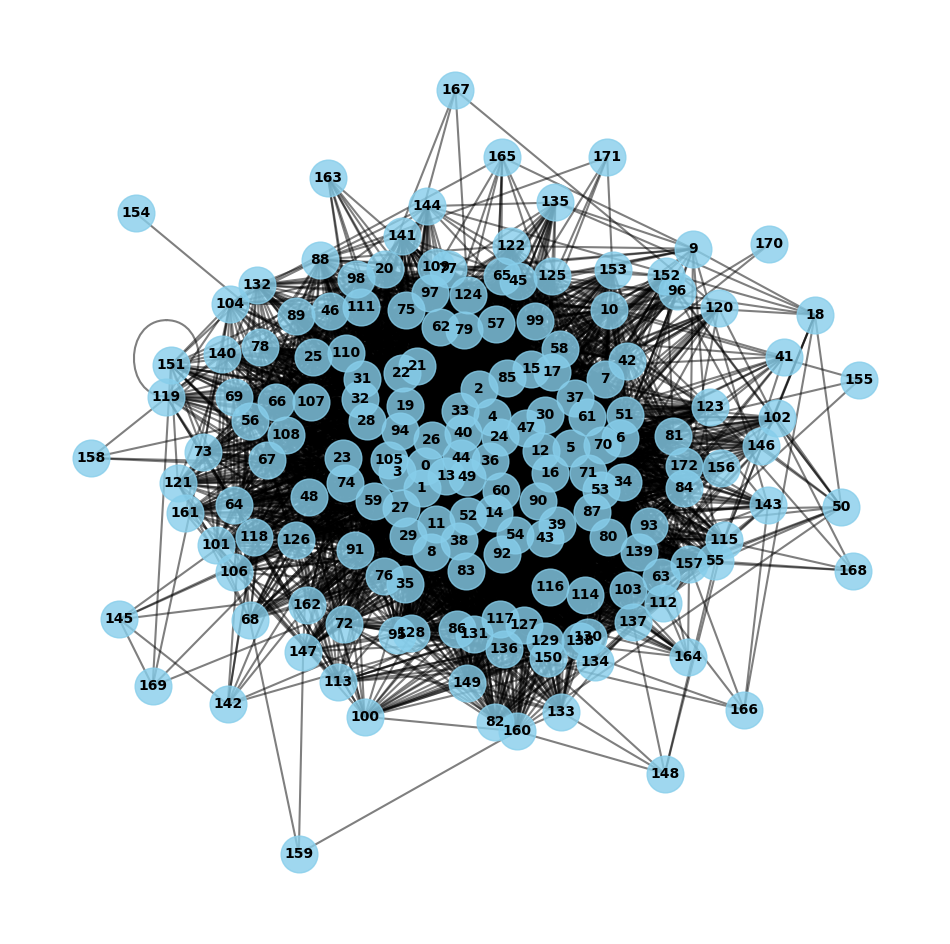

In [44]:
from torch_geometric.utils import to_networkx
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx_nodes(G,
                pos=nx.kamada_kawai_layout(G),
                node_size=700,
                node_color="skyblue",
                alpha=0.8
                )
nx.draw_networkx_edges(G,
                pos=nx.kamada_kawai_layout(G),
                width=1.5,
                alpha=0.5
                )
nx.draw_networkx_labels(G,
                pos=nx.kamada_kawai_layout(G),
                font_size=10,
                font_weight="bold"
                )
plt.show()

# 6. Modelo GAE

Es importante notar que utilizaremos GAT como la estructura de las capas

### Laplacian smoothing

El laplacian smoothing es un concepto clave en grafos y redes neuronales sobre grafos como GCNs o GATs, y se relaciona con la propagación de información entre vecinos. Esta técnica suaviza los vectores de caracteristicas x_i de cada nodo mezclandolos con los de sus vecinos, según la estructura del grafo. La formula descrita abajo nos dice: Si dos nodos están conectados, queiro que sus embeddings sean similares" z_i y z_j son los embeddings latentes del nodo i y su vecino j.

¿Qué ventajas obtenemos?: Estabilidad, consistencia local (los embeddings reflejan mejor la estructura del grafo), mejor detección de anomalías y reduce el overfitting.

La función de perdida de Huber se utiliza en el contexto de anomalías, pero dado que queremos comprometer mejor la estructura del grafo añadimos el smootness loss:

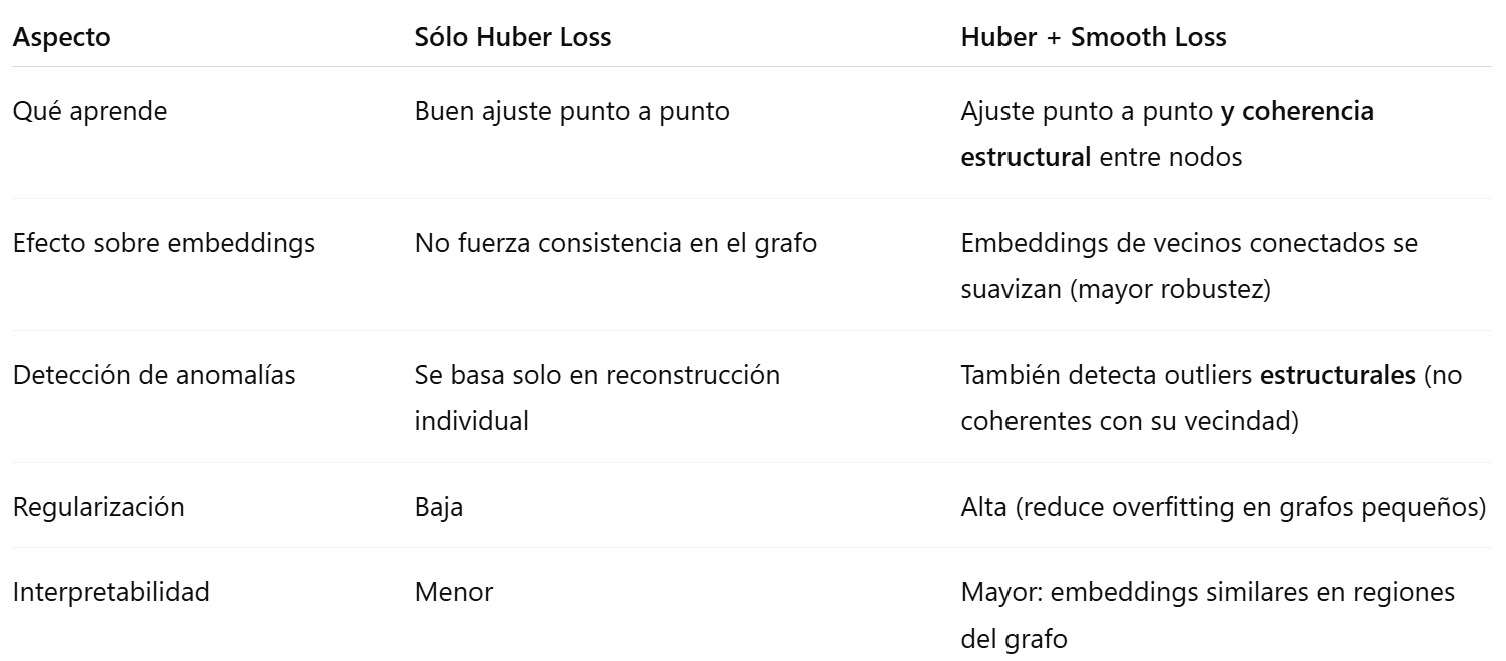

In [195]:

from IPython.display import display, Markdown
import torch
import torch.nn.functional as F
from torch.nn import HuberLoss


formula = r"$L_{smooth} = \Sigma_{(i,j)\in edges} ||Z_{i} - Z_{j} || ^2$"
display(Markdown(formula))


def hybrid_loss_huber(x_real, x_pred, z, edge_index, lambda_smooth=0.1, delta=1.0):
    # 1. Huber reconstruction loss
    huber = HuberLoss(delta=delta, reduction='mean')
    loss_recon = huber(x_pred, x_real)

    # 2. Smoothness loss
    row, col = edge_index
    smooth_diff = z[row] - z[col]
    loss_smooth = torch.mean(torch.norm(smooth_diff, dim=1) ** 2)

    # 3. Total loss
    total_loss = loss_recon + lambda_smooth * loss_smooth
    return total_loss, loss_recon.item(), loss_smooth.item()



$L_{smooth} = \Sigma_{(i,j)\in edges} ||Z_{i} - Z_{j} || ^2$

### Arquitectura

In [48]:
# Encoder with GAT and skip connections
class GNNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=5):
        super(GNNEncoder, self).__init__()
        self.num_layers = num_layers
        self.conv1 = GATConv(input_dim, hidden_dim, heads=2, concat=False)
        self.hidden_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))  # First GAT layer
        x = self.dropout(x)
        for conv in self.hidden_layers:  # GCN layers with skip connections
            x = F.relu(conv(x, edge_index)) + x  # Apply residual connection
            x = self.dropout(x)  # Dropout after each layer
        return x

# Decoder with MLP for reconstruction
class GNNDecoder(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(GNNDecoder, self).__init__()
        self.linear1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear2 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = self.dropout(z)
        return torch.sigmoid(self.linear2(z))  # Sigmoid for reconstruction

# Graph Autoencoder (GAE) model
class GNNAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=5):
        super(GNNAutoencoder, self).__init__()
        self.encoder = GNNEncoder(input_dim, hidden_dim, num_layers)
        self.decoder = GNNDecoder(hidden_dim, input_dim)

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index)
        reconstructed = self.decoder(z)
        return reconstructed


In [50]:
input_dim = data.x.shape[1]
hidden_dim = 128
model = GNNAutoencoder(input_dim,hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Reduce la tasa de aprendizaje en un factor de 0.5 si el error de construcción no mejora después de 5 épocas consecutivas
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# Train loop
num_epochs=1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    x_pred = model(data)
    z = model.encoder(data.x, data.edge_index)  # puedes evitar recomputar si ya tienes esto en forward()

    loss, loss_recon, loss_smooth = hybrid_loss_huber(
        x_real=data.x,
        x_pred=x_pred,
        z=z,
        edge_index=data.edge_index,
        lambda_smooth=0.1
    )

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Recon: {loss_recon:.4f} | Smooth: {loss_smooth:.4f}")

'''
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    reconstructed = model(data)
    loss = F.huber_loss(reconstructed, data.x)  # Compare reconstructed features to original
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

'''



In [196]:
with torch.no_grad():
    model.eval()
    z = model.encoder(data.x, data.edge_index)
    x_pred = model.decoder(z)

# Como usamos HuberLoss, evalúamos por nodo:
error_per_node = F.huber_loss(x_pred, data.x, reduction='none', delta=1.0)
recon_error = error_per_node.mean(dim=1).cpu().numpy()  # shape: [num_nodes]

'''
Otro método - no se ejecuta -
model.eval()
with torch.no_grad():
    reconstructed = model(data)
    reconstruction_error = torch.mean((reconstructed - data.x) ** 2, dim=1)
    print(f'Reconstruction Error: {reconstruction_error}')
'''

"\nOtro método - no se ejecuta -\nmodel.eval()\nwith torch.no_grad():\n    reconstructed = model(data)\n    reconstruction_error = torch.mean((reconstructed - data.x) ** 2, dim=1)\n    print(f'Reconstruction Error: {reconstruction_error}')\n"

# 7. Análisis de resultados GAE

In [197]:
### Contatenamos el error de reconstrucción
final['reconstruction_error_g'] = recon_error
final_2['reconstruction_error_g'] = recon_error

In [148]:
top_n = 10
indices = np.argsort(recon_error)[-top_n:]

print("Distribuidores más anómalos:")
for idx in indices:
    print(f"Distribuidor {idx} | Error: {recon_error[idx]:.4f}")

Distribuidores más anómalos:
Distribuidor 88 | Error: 2.9861
Distribuidor 34 | Error: 3.2558
Distribuidor 8 | Error: 3.3839
Distribuidor 106 | Error: 3.6129
Distribuidor 69 | Error: 3.6848
Distribuidor 4 | Error: 3.9039
Distribuidor 30 | Error: 4.1381
Distribuidor 15 | Error: 4.1727
Distribuidor 104 | Error: 4.9495
Distribuidor 133 | Error: 5.5950


In [63]:
percentiles = final['reconstruction_error_g'].quantile([0.25,0.5,0.75,0.8,0.9,0.95])
percentiles

0.25    0.253427
0.50    0.440979
0.75    0.994286
0.80    1.175462
0.90    1.942594
0.95    3.094012
Name: reconstruction_error, dtype: float64

In [198]:


# Supongamos que reconstruction_errors es tu tensor de errores de reconstrucción
# Convertimos el tensor a una lista o array para graficar
reconstruction_errors =  recon_error.numpy().flatten()  # si es un tensor de PyTorch o TensorFlow

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=reconstruction_errors)
plt.title("Reconstruction error distribution")
plt.xlabel("Reconstruction Error")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [72]:
percentil_0_25 = final[final['reconstruction_error'] < .2534]
percentil_25_50 = final[(final['reconstruction_error'] > 0.30) &(final['reconstruction_error'] < 0.4409)]
percentil_50_90 = final[(final['reconstruction_error'] > 0.52) &(final['reconstruction_error'] < 1.94)]
percentil_90 = final[final['reconstruction_error'] > 1.94]

C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\3202492687.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percentil_0_25['Percentile'] = '0-25%'
C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\3202492687.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percentil_25_50['Percentile'] = '25-50%'
C:\Users\SESA626862\AppData\Local\Temp\ipykernel_10888\3202492687.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

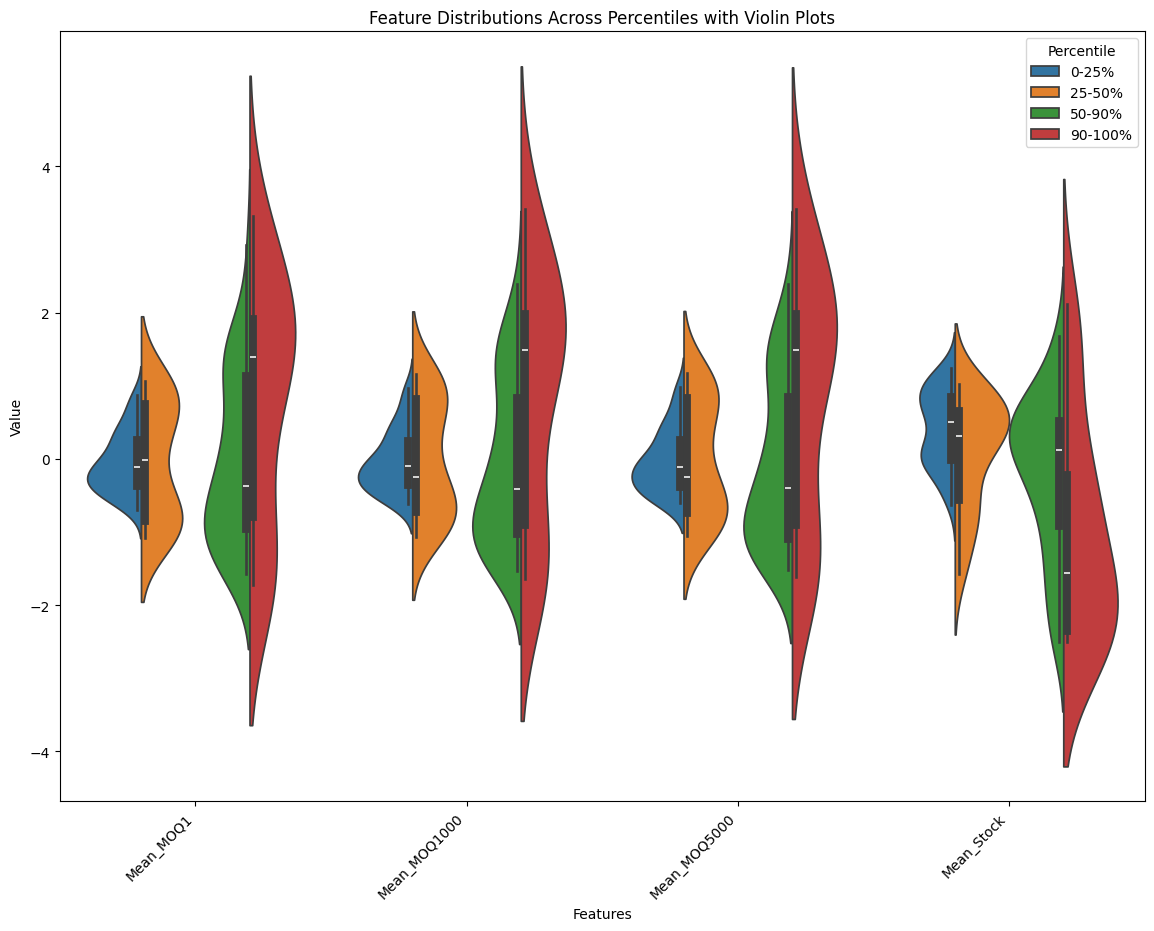

In [189]:
# Convert columns to numeric if not already
numeric_features = ['Mean_MOQ1', 'Mean_MOQ1000', 'Mean_MOQ5000',
                    'Mean_Stock']

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a 'Percentile' column to each DataFrame
percentil_0_25['Percentile'] = '0-25%'
percentil_25_50['Percentile'] = '25-50%'
percentil_50_90['Percentile'] = '50-90%'
percentil_90['Percentile'] = '90-100%'

# Combine all DataFrames
combined_data = pd.concat([percentil_0_25, percentil_25_50, percentil_50_90, percentil_90])

# Melt the DataFrame to make it suitable for sns.violinplot
melted_data = combined_data.melt(id_vars='Percentile', value_vars=numeric_features,
                                 var_name='Feature', value_name='Value')

# Plot violin plots with hue for Percentiles
plt.figure(figsize=(14, 10))
sns.violinplot(data=melted_data, x='Feature', y='Value', hue='Percentile', split=True)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Distributions Across Percentiles with Violin Plots')
plt.ylabel('Value')
plt.xlabel('Features')
plt.legend(title='Percentile')
plt.show()

### ¿Relación del error de reconstrucción con los brokers?

In [129]:
is_broker = df_clean[['Authorized Distributor','Distributor + Country']].groupby('Distributor + Country').max()

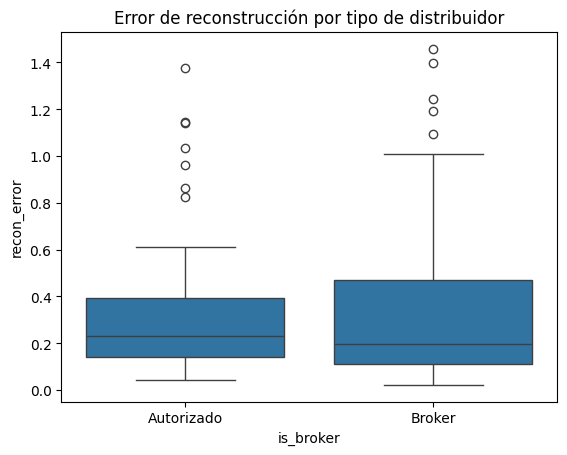

In [131]:
import pandas as pd
df_eval = pd.DataFrame({
    "distributor_id": range(len(recon_error)),
    "recon_error": recon_error,
    "is_broker": is_broker["Authorized Distributor"]  # suponiendo que se cargó como parte de data
})

# Boxplot
import seaborn as sns

sns.boxplot(x="is_broker", y="recon_error", data=df_eval)
plt.xticks([0, 1], ["Autorizado", "Broker"])
plt.title("Error de reconstrucción por tipo de distribuidor")
plt.show()

La figura muestra el error de reconstrucción absoluto por nodo (distribuidor) y atributo, ordenado por el error total descendente. Se observa que ciertos nodos presentan errores significativamente altos en atributos específicos como Max_MOQ1, Max_MOQ1000 y Max_MOQ5000, lo que sugiere dificultad del modelo para reconstruir valores extremos. De forma interesante, atributos como Mean_Stock y k_Stock también exhiben errores localizados, indicando sensibilidad estructural del modelo hacia el comportamiento de inventario.

Este patrón confirma que el GAE no solo responde a outliers univariantes, sino también a combinaciones estructurales atípicas. Además, el hecho de que los errores estén dispersos y no concentrados en una sola variable refuerza la complejidad latente del espacio de reconstrucción, característica propia de distribuciones industriales heterogéneas.

Para comprender mejor la naturaleza de las anomalías detectadas, realizamos un análisis de reconstrucción en dos niveles. En primer lugar, se visualizó el error absoluto de reconstrucción por nodo y atributo mediante un heatmap (Figura X). Esta visualización mostró que algunos distribuidores presentan errores elevados en atributos específicos como Max_MOQ1, Mean_Stock y k_Stock, lo que sugiere inconsistencias estructurales más allá de valores extremos individuales.

Como complemento, se agruparon los nodos según su percentil de error total de reconstrucción (0–25%, 25–50%, 50–90% y 90–100%) y se analizaron las distribuciones de atributos clave mediante violin plots (Figura Y). Se observó que el grupo del percentil más alto (90–100%) presenta una dispersión y asimetría mucho mayores, especialmente en Mean_MOQ1000 y Mean_Stock. Esto confirma que el modelo GAE es especialmente sensible a irregularidades estructurales latentes que se manifiestan como desviaciones multivariadas, y no únicamente como outliers univariantes.

En conjunto, estas visualizaciones aportan evidencia sólida de que el GAE captura señales de anomalía complejas —tanto específicas por atributo como combinadas entre ellos— que no son fácilmente detectables mediante métodos tabulares clásicos.

Hacemos una prueba estadistica para ver si hay una relación significativa entre los brokers con el error de reconstrucción

In [132]:
from scipy.stats import mannwhitneyu

auth = df_eval[df_eval.is_broker == 0]["recon_error"]
broker = df_eval[df_eval.is_broker == 1]["recon_error"]

stat, p_value = mannwhitneyu(auth, broker, alternative='two-sided')
print(f"Test Mann-Whitney U | p-value = {p_value:.5f}")

Test Mann-Whitney U | p-value = 0.51185


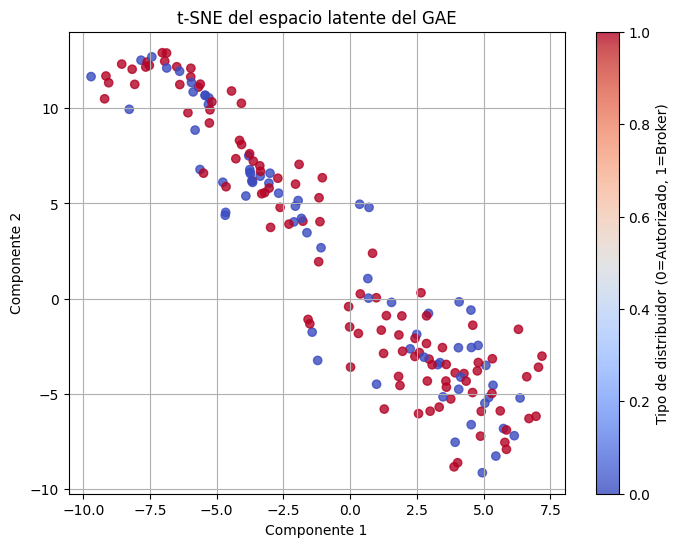

In [139]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Asegúrate de estar en evaluación
model.eval()
with torch.no_grad():
    z = model.encoder(data.x, data.edge_index)  # shape: [173, hidden_dim]

# Convierte a NumPy
z_np = z.cpu().numpy()
labels = is_broker["Authorized Distributor"]

# Aplica t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
z_2d = tsne.fit_transform(z_np)

# Visualiza
plt.figure(figsize=(8,6))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.8)
plt.title("t-SNE del espacio latente del GAE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(scatter, label='Tipo de distribuidor (0=Autorizado, 1=Broker)')
plt.grid(True)
plt.show()

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


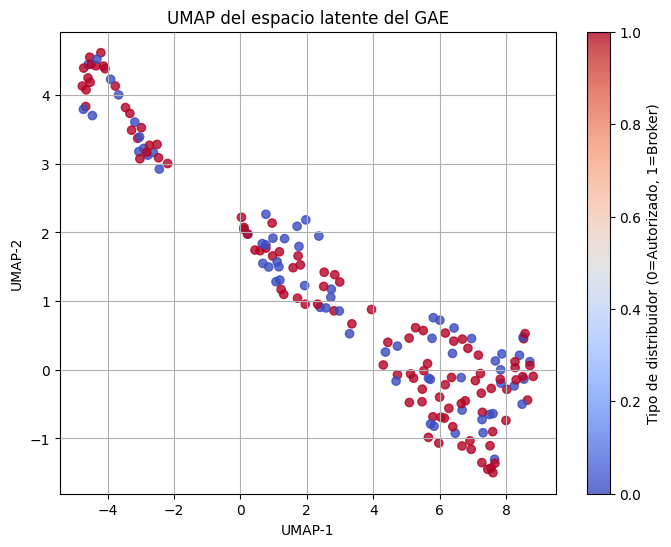

In [141]:
import umap
import matplotlib.pyplot as plt

# Asegúrate de tener z como tensor (n_nodes x hidden_dim)
z_np = z.cpu().numpy()
labels = is_broker["Authorized Distributor"] # 0 = autorizado, 1 = broker

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
z_umap = umap_model.fit_transform(z_np)

# Visualización
plt.figure(figsize=(8,6))
scatter = plt.scatter(z_umap[:, 0], z_umap[:, 1], c=labels, cmap='coolwarm', alpha=0.8)
plt.title("UMAP del espacio latente del GAE")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label='Tipo de distribuidor (0=Autorizado, 1=Broker)')
plt.grid(True)
plt.show()

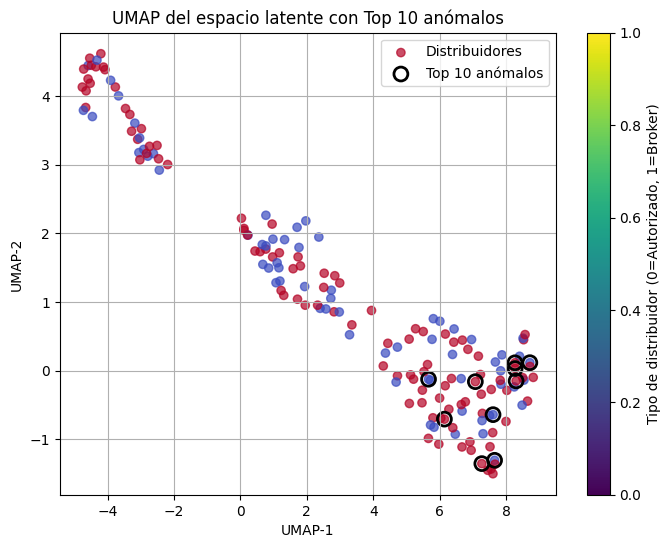

In [142]:
# Obtener los índices del Top 10 por error de reconstrucción
top_n = 10
top_indices = np.argsort(recon_error)[-top_n:]

# Crear figura
plt.figure(figsize=(8, 6))

# Distribuidores normales
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=labels, cmap='coolwarm', alpha=0.7, label='Distribuidores')

# Top 10 anómalos
plt.scatter(
    z_umap[top_indices, 0],
    z_umap[top_indices, 1],
    facecolors='none',
    edgecolors='black',
    linewidths=2,
    marker='o',
    s=100,
    label='Top 10 anómalos'
)

plt.title("UMAP del espacio latente con Top 10 anómalos")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Tipo de distribuidor (0=Autorizado, 1=Broker)')
plt.legend()
plt.grid(True)
plt.show()

Hemos notado que no hay evidencia que muestre que el error de reconstrucción este asociado intrisecamente con la variable de si es broker o no

## 7.2 Análisis de las variables de las observaciones anómalas vs. las normales

In [145]:
features = ['Mean_MOQ1','Max_MOQ1','Min_MOQ1','Std_MOQ1',
'sk_MOQ1','k_MOQ1','Mean_MOQ1000','Max_MOQ1000','Min_MOQ1000','Std_MOQ1000','sk_MOQ1000','k_MOQ1000','Mean_MOQ5000','Max_MOQ5000','Min_MOQ5000','Std_MOQ5000','sk_MOQ5000','k_MOQ5000','Mean_Stock','Max_Stock','Min_Stock','Std_Stock',
'sk_Stock','k_Stock','Mean_MOQ']

In [156]:
top10 = final_2.nlargest(10, 'reconstruction_error_g')
bottom10 = final_2.nsmallest(10, 'reconstruction_error_g')

summary_top = top10[features].mean().to_frame(name='Top10_mean')
summary_bottom = bottom10[features].mean().to_frame(name='Bottom10_mean')

comparison_df = pd.concat([summary_top, summary_bottom], axis=1)

In [157]:
comparison_df

,Top10_mean,Bottom10_mean
Mean_MOQ1,244.694362,1.404581e+01
Max_MOQ1,947.772000,4.645724e+03
Min_MOQ1,48.788000,1.112200e-02
Std_MOQ1,291.985749,1.034052e+02
sk_MOQ1,1.054645,2.545847e+01
k_MOQ1,2.716318,1.005040e+03
Mean_MOQ1000,240.334563,1.240781e+01
Max_MOQ1000,946.224000,4.120200e+03
Min_MOQ1000,46.676000,9.657000e-03
Std_MOQ1000,289.979390,8.989779e+01


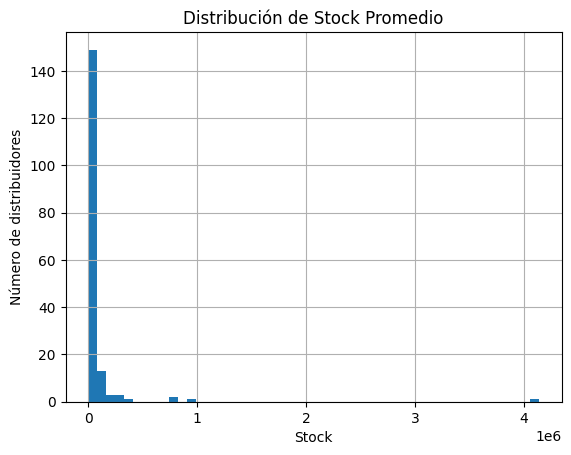

In [160]:
import matplotlib.pyplot as plt
plt.hist(final_2['Mean_Stock'], bins=50)
plt.title("Distribución de Stock Promedio")
plt.xlabel("Stock")
plt.ylabel("Número de distribuidores")
plt.grid(True)
plt.show()

In [ ]:
# Supongamos que tienes X_orig y X_recon como NumPy arrays
# Ambos de forma (n_nodos, n_features)

X_recon = x_pred.detach().cpu().numpy()
X_orig = data.x.detach().cpu().numpy()

# Error absoluto por feature
recon_error = np.abs(X_orig - X_recon)

# Si quieres que los nodos más anómalos estén arriba, puedes ordenar por error total
error_total = recon_error.mean(axis=1)
sorted_idx = np.argsort(-error_total)  # mayor a menor

# DataFrame para heatmap
df_error = pd.DataFrame(recon_error[sorted_idx], columns=f)

# Visualización
plt.figure(figsize=(12, 8))
sns.heatmap(df_error, cmap="YlOrRd", xticklabels=True, yticklabels=False, cbar_kws={"label": "Recon Error"})
plt.title("Heatmap de Error de Reconstrucción por Nodo y Atributo")
plt.xlabel("Atributos")
plt.ylabel("Distribuidores ordenados por error")
plt.tight_layout()
plt.show()

# ISOLATION FOREST (IF)

Ahora, comparamos nuestra GAE con un método clásico -IF-

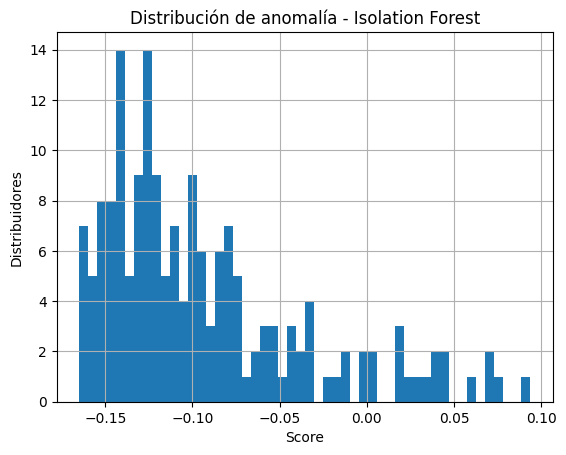

In [167]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

X_scaled= final[features].values

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_scores = -iso_forest.fit(X_scaled).decision_function(X_scaled)  # mayor = más anómalo  # mayores valores = más anómalos
iso_top10_indices = np.argsort(iso_scores)[-10:]


## Comparación

In [172]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
recon_error_scaled = scaler.fit_transform(recon_error.reshape(-1, 1)).flatten()
iso_scores_scaled = scaler.fit_transform(iso_scores.reshape(-1, 1)).flatten()

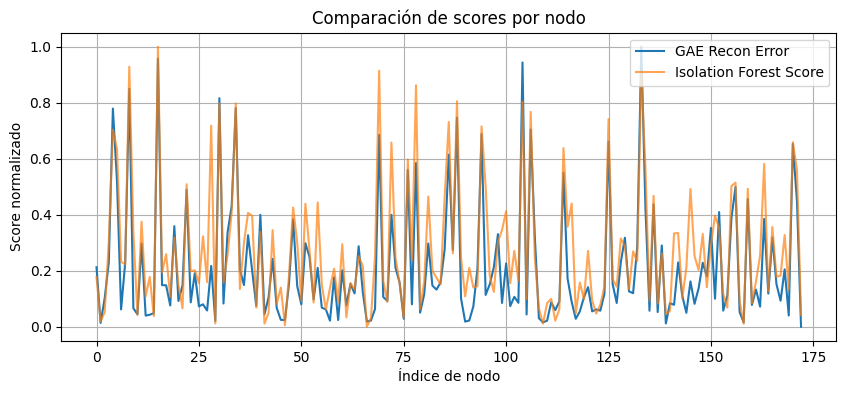

In [173]:
plt.figure(figsize=(10,4))
plt.plot(recon_error_scaled, label='GAE Recon Error')
plt.plot(iso_scores_scaled, label='Isolation Forest Score', alpha=0.7)
plt.legend()
plt.title("Comparación de scores por nodo")
plt.xlabel("Índice de nodo")
plt.ylabel("Score normalizado")
plt.grid(True)
plt.show()

In [174]:
top10_gae = np.argsort(recon_error)[-10:]
top10_iso = np.argsort(iso_scores)[-10:]

print("Top 10 GAE:", top10_gae)
print("Top 10 Isolation Forest:", top10_iso)

# Solapamiento
print("Coinciden en:", set(top10_gae) & set(top10_iso))

Top 10 GAE: [ 94 106  88   4  34  30   8 104  15 133]
Top 10 Isolation Forest: [106  34  30 104  88  78 133  69   8  15]
Coinciden en: {34, 133, 104, 8, 106, 15, 88, 30}


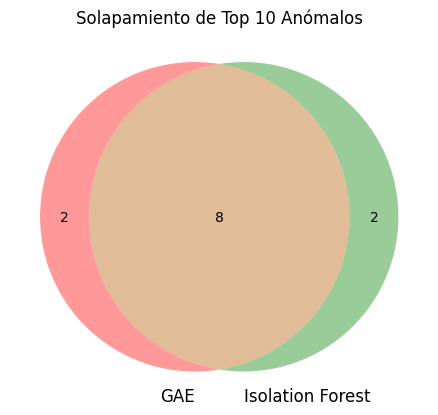

In [177]:
from matplotlib_venn import venn2
venn2([set(top10_gae), set(top10_iso)], set_labels=('GAE', 'Isolation Forest'))
plt.title("Solapamiento de Top 10 Anómalos")
plt.show()

In [179]:
import pandas as pd

# Supón que estos son tus índices
top10_gae = set([ 94 ,106 , 88  , 4 , 34,  30,   8 ,104 , 15 ,133])
top10_iso = set([106 , 34  ,30, 104,  88 , 78,133,  69,   8 , 15])

# Define nodos únicos por modelo
only_gae = top10_gae - top10_iso
only_iso = top10_iso - top10_gae

# Carga tu dataframe de features reales (sin escalar si quieres interpretabilidad)
# df_features = pd.read_csv("features_originales.csv")  <-- reemplaza esto por tus datos reales
# Aquí simulo features:
import numpy as np
np.random.seed(42)
df_features = pd.DataFrame(
    data=final_2[features],
    columns=['Mean_MOQ1', 'Max_MOQ1', 'Min_MOQ1', 'Std_MOQ1', 'Mean_Stock', 'Max_Stock']
)

# Extraer nodos
df_gae = df_features.loc[list(only_gae)].copy()
df_iso = df_features.loc[list(only_iso)].copy()

df_gae['Método'] = 'Solo GAE'
df_iso['Método'] = 'Solo Isolation Forest'

# Unir en un solo dataframe para análisis
df_comparacion = pd.concat([df_gae, df_iso])
print(df_comparacion)

      Mean_MOQ1     Max_MOQ1  Min_MOQ1      Std_MOQ1    Mean_Stock  \
4    225.114589     567.6500   79.0000    107.022513  6.534247e+00   
94     2.350000       3.1000    1.6000      1.060660  5.000000e+02   
69  2770.679416  344990.0000    0.0400  29457.207186  3.052774e+02   
78    89.970750     368.8143   14.2795    138.890782  4.139066e+06   

     Max_Stock                 Método  
4         18.0               Solo GAE  
94      1000.0               Solo GAE  
69     14998.0  Solo Isolation Forest  
78  22538494.0  Solo Isolation Forest  


### Conclusiones hasta aqui:
El modelo GAE detecta outliers de bajo volumen (stock/actividad) que un método tabular clásico como IF ignora.

IF detecta outliers extremos absolutos (valores altísimos) aunque estén bien integrados en la estructura del grafo.

Ambos modelos ofrecen puntos de vista complementarios sobre qué es “anómalo” — y eso es valioso en escenarios reales sin etiquetas.

La intersección de 8/10 anómalos valida que tu modelo no genera ruido arbitrario.

# ¿Ahora que pasa si utilizamos los Z del GAE y lo metemos al IF?

In [180]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# 👉 Usa tus propios embeddings en lugar de este ejemplo:
# z = encoder(x, edge_index).detach().cpu().numpy()


# Aplicar Isolation Forest sobre z
iso = IsolationForest(contamination=0.1, random_state=42)
score_z = -iso.fit(z).decision_function(z)  # score alto = más anómalo

# Top 10
top10_z_idx = np.argsort(score_z)[-10:]

# Mostrar nodos anómalos
df_result = pd.DataFrame({
    'Nodo': np.arange(len(score_z)),
    'Score_IF(z)': score_z,
    'Es_top10': [i in top10_z_idx for i in range(len(score_z))]
})

print(df_result[df_result['Es_top10'] == True])

     Nodo  Score_IF(z)  Es_top10
73     73     0.139065      True
102   102     0.081876      True
134   134     0.119399      True
145   145     0.103824      True
154   154     0.091014      True
155   155     0.350313      True
159   159     0.271177      True
167   167     0.106593      True
170   170     0.358594      True
171   171     0.264931      True


In [181]:

set_gae = set([ 94 ,106 , 88  , 4 , 34,  30,   8 ,104 , 15 ,133])
set_ifx = set([106 , 34  ,30, 104,  88 , 78,133,  69,   8 , 15])
set_ifz = set([73, 102, 134, 145, 154, 155, 159, 167, 170, 171])

# Coincidencias
print("GAE ∩ IF(z):", set_gae & set_ifz)
print("IF(x) ∩ IF(z):", set_ifx & set_ifz)

GAE ∩ IF(z): set()
IF(x) ∩ IF(z): set()


La aplicación de Isolation Forest sobre los embeddings latentes generados por el GAE (IF(z)) reveló un conjunto completamente distinto de nodos anómalos en comparación con los identificados por métodos clásicos (IF(x)) y el error de reconstrucción del GAE. Esta total disyunción sugiere que el espacio latente z aprendido por el GNN contiene información estructural no capturada por los atributos tabulares ni por la reconstrucción directa. La complementariedad entre IF(z) y los demás enfoques resalta el valor de utilizar representaciones aprendidas para descubrir nuevos tipos de anomalías.

In [183]:
top10_gae = set([94, 106, 88, 4, 34, 30, 8, 104, 15, 133])
top10_iso = set([106, 34, 30, 104, 88, 78, 133, 69, 8, 15])
top10_ifz = set([73, 102, 134, 145, 154, 155, 159, 167, 170, 171])  # desde IF(z)

only_gae = top10_gae - top10_iso
only_iso = top10_iso - top10_gae
only_ifz = top10_ifz - (top10_gae | top10_iso)  # nodos únicos de IF(z)

# Cargar tus features reales desde final_2
df_features = final_2[[
    'Mean_MOQ1', 'Max_MOQ1', 'Min_MOQ1', 'Std_MOQ1', 'Mean_Stock', 'Max_Stock'
]]

# Extraer nodos por grupo
df_gae = df_features.loc[list(only_gae)].copy()
df_iso = df_features.loc[list(only_iso)].copy()
df_ifz = df_features.loc[list(only_ifz)].copy()

df_gae['Método'] = 'Solo GAE'
df_iso['Método'] = 'Solo Isolation Forest'
df_ifz['Método'] = 'Solo IF(z)'

# Unir todo
df_comparacion = pd.concat([df_gae, df_iso, df_ifz]).reset_index().rename(columns={'index': 'ID Nodo'})

# Mostrar tabla
print(df_comparacion)

    ID Nodo    Mean_MOQ1      Max_MOQ1  Min_MOQ1      Std_MOQ1    Mean_Stock  \
0         4   225.114589     567.65000  79.00000    107.022513  6.534247e+00   
1        94     2.350000       3.10000   1.60000      1.060660  5.000000e+02   
2        69  2770.679416  344990.00000   0.04000  29457.207186  3.052774e+02   
3        78    89.970750     368.81430  14.27950    138.890782  4.139066e+06   
4       102    74.853706   38321.89000   0.00040    680.697352  1.993093e+04   
5       134    25.100750      56.43000   2.70700     26.860058  2.860500e+03   
6       167     2.171477     165.52000   0.00220     12.580672  1.925427e+04   
7        73     7.404921     172.04000   0.00150     12.713994  2.259097e+04   
8       170   332.534351    2498.00000  35.00000    306.220014  4.748092e+00   
9       171   179.000316    6987.99000   0.17000    529.866710  0.000000e+00   
10      145     2.088946    4774.19000   0.00050     41.854167  2.744238e+05   
11      154     2.419875     776.36486  

Se realizó un análisis comparativo entre los nodos identificados de forma única por cada método de detección de anomalías: el Autoencoder de Grafos (GAE), el algoritmo Isolation Forest aplicado sobre atributos originales (IF(x)) y sobre embeddings latentes (IF(z)). Los resultados muestran que cada enfoque identifica perfiles anómalos distintos. Los nodos únicos del GAE presentan niveles de stock extremadamente bajos (Mean_Stock ≈ 6.5), lo que sugiere anomalías estructurales o de distribución difíciles de detectar mediante métodos tabulares clásicos. En contraste, IF(x) detecta distribuidores con valores tabulares extremos, como MOQ muy altos o stock máximos que superan los 22 millones de unidades. De manera destacada, IF(z) detectó un conjunto completamente distinto de nodos, sin coincidencias con GAE ni con IF(x). Estos nodos presentan patrones latentes atípicos, con máximos de stock que superan los 100 millones, lo cual indica que el espacio latente aprendido por el GAE captura estructuras y relaciones no evidentes en los datos tabulares. Esta complementariedad sugiere que integrar perspectivas estadísticas y topológicas mejora significativamente la detección de anomalías en entornos industriales.